# SHARPy TS without PDEControl

Folder exists: output/pazy_M16N1Ms20_alpha0001_skin0_te0/
Loaded 104 cases
Saved velocity/eigs array to ./output/pazy/output/fluttersharpy_skin_off_te0//velocity_eigenvalues_alpha0001.txt
[62.83836522597769]
Flutter speeds [62.83836522597769]
RUNNING SHARPY 0.010000 78.547957

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    Al

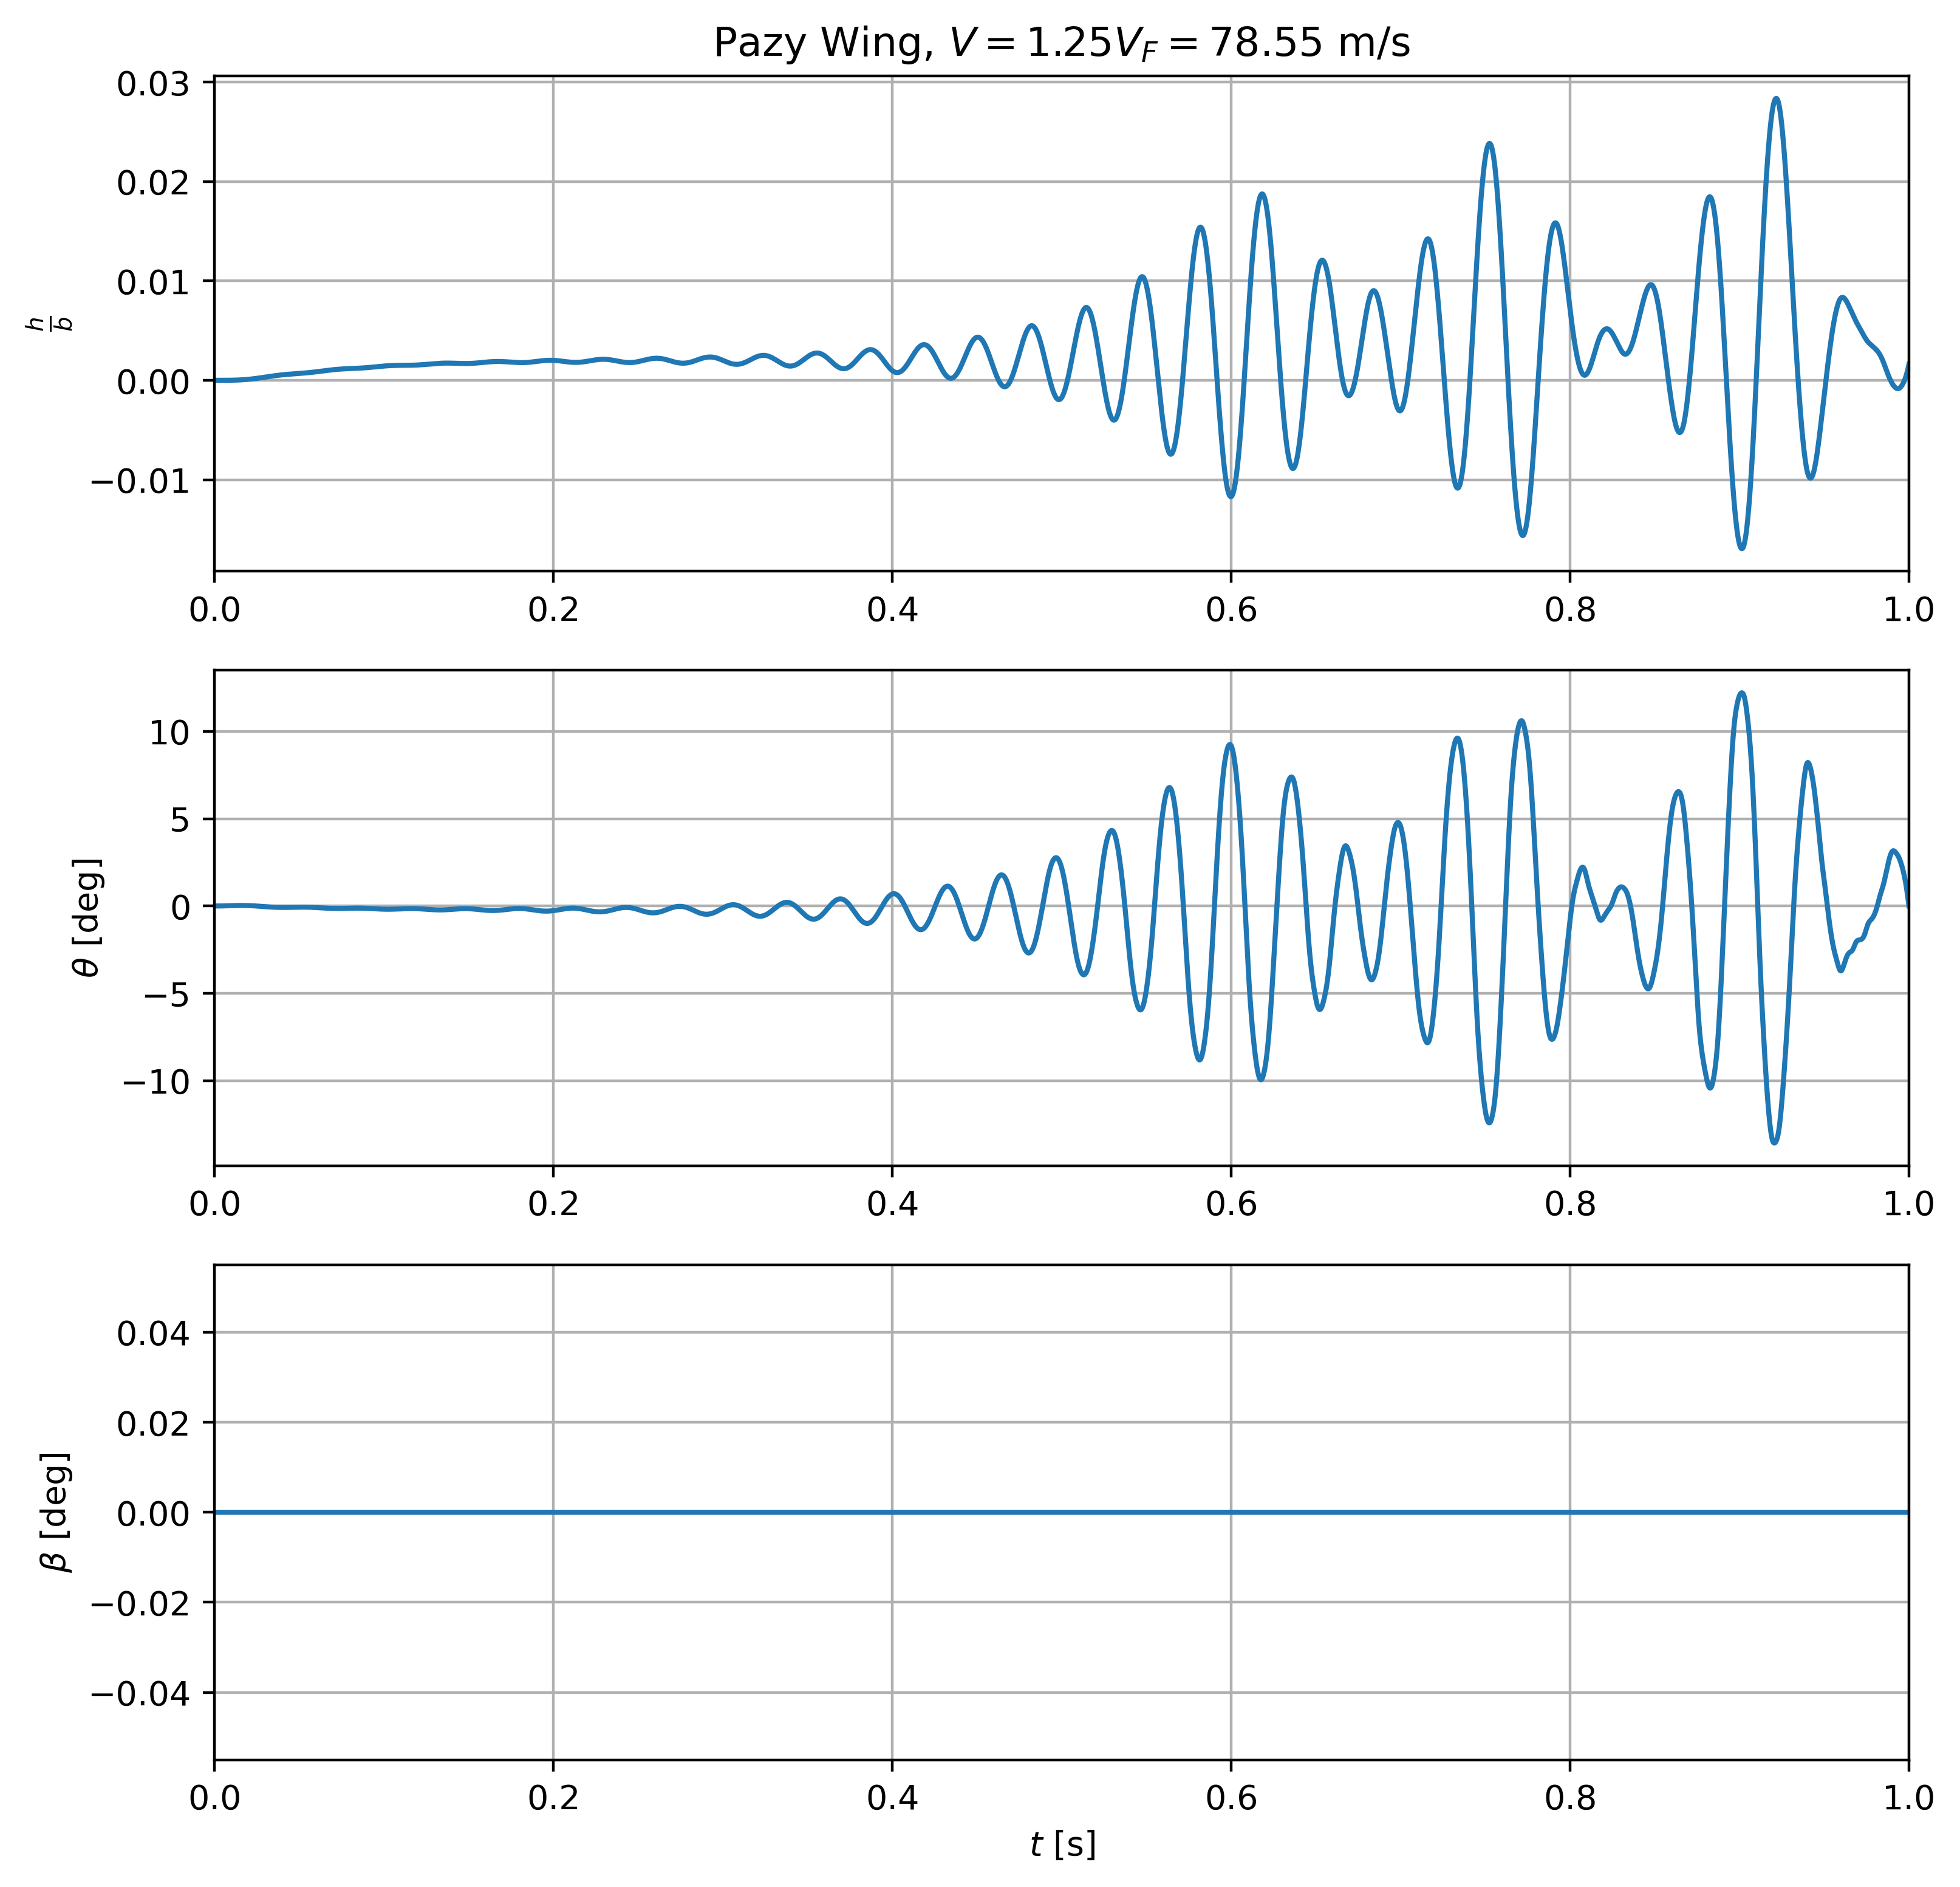

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.interpolate
from matplotlib.lines import Line2D
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['figure.figsize'] = (8, 6)
# plt.style.use('dark_background')
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('pazy/sharpy-analysis-tools/')
sys.path.append('pazy/pazy_model/')
import linear.stability as stability
from generate_deformed_tseries import generate_pazy_tseries
import postprocess_deformed_flutter
controlled = False
flap_frac = 0.25
chord_frac = 0.25

# M = 16  # default 16
# N = 1  # default 1
# Ms = 20  # default 20
skin_on = False  # default False
trailing_edge_weight = False  # default False
alpha = 0.01
gravity_on = False
end_time = 1

M = 16
N = 1
Ms = 20

pazy_settings = {'num_elem': N,
                 'surface_m': M,
                'controlled': controlled,
                'cs_deflection': [0, 0],
                'cs_span_frac': flap_frac,
                'cs_chord_frac': chord_frac,
                'skin_on': 'off',
                'discretisation_method': 'michigan',
                }


from datetime import datetime
# u_inf_vec = np.linspace(10, 90, 81)
# u_inf_vec = [83]

output_folder_nocontrol = 'output/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
cases_subfolder_nocontrol = '/M{:g}N{:g}Ms{:g}_skin{:g}_te{:g}/'.format(M, N, Ms, skin_on, trailing_edge_weight)
batch_log = output_folder_nocontrol + 'batch_log_alpha{:04g}'.format(alpha*100)

try:
    os.mkdir(output_folder_nocontrol)
    print(f'Created folder: {output_folder_nocontrol}')
except FileExistsError:
    print(f'Folder exists: {output_folder_nocontrol}')
    pass

vf = postprocess_deformed_flutter.main(M=M, N=N, Ms=Ms, alpha=[alpha], skin=skin_on, te=trailing_edge_weight)
print('Flutter speeds', vf)


with open('{:s}.txt'.format(batch_log), 'w') as f:
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    f.write('SHARPy launch - START\n')
    f.write("date and time = %s\n\n" % dt_string)

    for i, u_inf in enumerate(vf[:1]):
        multiplier = 1.25  # for plot title
        u_inf *= multiplier
        print('RUNNING SHARPY %f %f\n' % (alpha, u_inf))
        case_name = 'pazy_uinf{:04g}_alpha{:04g}'.format(u_inf*10, alpha*100)
        
        dt = 0.1/M/u_inf
        n_tsteps = int(end_time / dt)
        if alpha == 0: alpha += 1e-2
        # n_tsteps = 10
        # end_time = dt * n_tsteps
        
        try:
            sharpy_output_nocontrol = generate_pazy_tseries(u_inf,
                                                            case_name,
                                                            output_folder=output_folder_nocontrol,
                                                            cases_subfolder=cases_subfolder_nocontrol,
                                                            M=M,
                                                            N=N,
                                                            Ms=Ms,
                                                            alpha=alpha,
                                                            gravity_on=gravity_on,
                                                            skin_on=skin_on,
                                                            trailing_edge_weight=trailing_edge_weight,
                                                            model_settings=pazy_settings,
                                                            num_cores=24,
                                                            end_time=end_time,
                                                            )
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s Ran case %i :::: u_inf = %f\n\n' % (dt_string, i, u_inf))
            
            # print(sharpy_output_nocontrol.structure.timestep_info[0].in_global_AFoR)
            # print(np.degrees(sharpy_output_nocontrol.structure.timestep_info[0].psi))
            # print(np.degrees(sharpy_output_nocontrol.structure.timestep_info[0].quat))
        
            time = np.linspace(0, dt*n_tsteps, n_tsteps)
            tstep_info = sharpy_output_nocontrol.structure.timestep_info
            tip_pos_nocontrol = np.zeros((n_tsteps))
            tip_rot_nocontrol = np.zeros((n_tsteps))
            tip_pos_nocontrol[tip_pos_nocontrol==0] = None
            tip_rot_nocontrol[tip_rot_nocontrol==0] = None
            for it in range(n_tsteps):
                try:
                    tip_pos_nocontrol[it] = tstep_info[it].pos[tstep_info[it].num_node//2-1, 2]
                    tip_rot_nocontrol[it] = tstep_info[it].psi[tstep_info[it].num_elem//2-1, -1, 1]
                except IndexError:
                    pass
            tip_rot_nocontrol = np.degrees(tip_rot_nocontrol)
            aileron = np.zeros((n_tsteps))
            aileron = np.degrees(aileron)
            
            # save nocontrol output to save some time
            file_out = np.vstack([time, tip_pos_nocontrol, tip_rot_nocontrol, aileron]).T  # time, h, theta, beta
            ustr = str(round(u_inf, 2)).replace('.', '_')
            filename = f'{output_folder_nocontrol}/tip_output_{ustr}.txt'
            np.savetxt(filename, file_out, delimiter=',')
            print(filename)

            # plotting, optional (plotted in conjunction with controlled output below)
            fig, ax = plt.subplots(3, figsize=(9, 9), dpi=200)

            ax[0].plot(time, tip_pos_nocontrol / (2*0.55), '-')
            ax[1].plot(time, tip_rot_nocontrol, '-')
            ax[2].plot(time, aileron, '-')

            ax[0].set_title(r'Pazy Wing, $V = {}V_F = {}$ m/s'.format(round(multiplier, 2), round(u_inf, 2)))
            ax[0].set_xlim(0, end_time)
            ax[1].set_xlim(0, end_time)
            ax[2].set_xlim(0, end_time)

            ax[0].grid()
            ax[1].grid()
            ax[2].grid()
            ax[2].set_xlabel(r"$t$ [s]")
            ax[0].set_ylabel(r"$\frac{h}{b}$")
            ax[1].set_ylabel(r'$\theta$ [deg]')
            ax[2].set_ylabel(r'$\beta$ [deg]')

            ustr = str(round(u_inf, 3)).replace('.', '_')
            #     plt.savefig('../Desktop/goland_vf_m{}n{}ms{}_nocontrol.png'.format(M, N, M_star_fact))
            plt.show()
        
        except AssertionError:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('./{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s ERROR RUNNING case %f\n\n' % (dt_string, u_inf))



# SHARPy TS with PDEControl

In [3]:
import scipy.optimize as opt
import scipy.signal as sig
import os
import sys
import numpy as np
sys.path.append('pazy/pazy_model/')
from generate_deformed_tseries import generate_pazy_tseries
import postprocess_deformed_flutter
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.interpolate
from matplotlib.lines import Line2D
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['figure.figsize'] = (8, 6)
# plt.style.use('dark_background')
sys.path.append('pazy/sharpy-analysis-tools/')
import linear.stability as stability
from generate_deformed_tseries import generate_pazy_tseries
import postprocess_deformed_flutter

skin_on = False  # default False
trailing_edge_weight = False  # default False
alpha = 0.01
gravity_on = False
end_time = 1
dt_multiplier = 2   
span = 2 * 0.55

M = 16  # default 16
N = 1  # default 1
Ms = 20  # default 20

flap_frac = 0.5
chord_frac = 0.5
pazy_settings = {'num_elem': N,
                 'surface_m': M,
                'controlled': True,
                'controller_type': 'pde',
                'cs_deflection': [0, 0],
                'cs_span_frac': flap_frac,
                'cs_chord_frac': chord_frac,
                'skin_on': skin_on,
                'discretisation_method': 'michigan',
                }

Tu = 1/4.4  # oscillation period
Ku = None  # gain of stable & consistent oscillations

controller_id = {'aileron': 'ControlSurfacePdeController'}
controller_noise = False
controller_noise_settings = {'noise_mode': 'amplitude', 'max_percentage': 100, 'max_amplitude': np.radians(0.05),}
controller_lag_ms = 0

controller_rp = 0
controller_ri = 0
controller_rd = 0
controller_rd2 = 0

# disable all tip theta
# controller_rp = controller_ri = controller_rd = controller_rd2 = 0

tipr_active = (controller_rp!=0 or controller_ri!=0 or controller_rd!=0 or controller_rd2!=0)

controller_zp = 0  # no negative
controller_zi = 0
controller_zd = 0 
controller_zd2 = 0
tipz_active = (controller_zp!=0 or controller_zi!=0 or controller_zd!=0 or controller_zd2!=0)

controller_tp = 100
controller_ti = 0
controller_td = 0.5  # sqrt(kp) * 2 * 0.8
controller_td2 = 0
controller_td3 = 0
controller_td4 = 0

# disable all theta
# controller_tp = controller_ti = controller_td = controller_td2 = controller_td3 = controller_td4 = 0

t_active = (controller_tp!=0 or controller_ti!=0)
td_active = (controller_td!=0)
tdd_active = (controller_td2!=0 or controller_td3!=0 or controller_td4!=0)

p_steps = 1
i_steps = 1
d_steps = 1
d2_steps = d_steps

from datetime import datetime
# u_inf_vec = np.linspace(10, 90, 81)
# u_inf_vec = [83]

output_folder = './output/controlled/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}_control/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
cases_subfolder = '/M{:g}N{:g}Ms{:g}_skin{:g}_te{:g}_control/'.format(M, N, Ms, skin_on, trailing_edge_weight)
batch_log = output_folder + 'batch_log_alpha{:04g}_control'.format(alpha*100)

try:
    os.makedirs(output_folder)
    print(f'Created folder: {output_folder}')
except FileExistsError:
    print(f'Folder exists: {output_folder}')
    pass

if alpha == 0:
    alpha_1 = 0.01
vf = postprocess_deformed_flutter.main(M=M, N=N, Ms=Ms, alpha=[alpha], skin=skin_on, te=trailing_edge_weight)
print('Flutter speeds', vf)

with open('{:s}.txt'.format(batch_log), 'w') as f:
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    f.write('SHARPy launch - START\n')
    f.write("date and time = %s\n\n" % dt_string)
    for i, u_inf in enumerate(vf[:1]):
        multiplier = 1
        u_inf *= multiplier
        print('RUNNING SHARPY %f %f\n' % (alpha, u_inf))
        case_name = 'pazy_uinf{:04g}_alpha{:04g}'.format(u_inf*10, alpha*100)
        
        dt = 0.1/M/u_inf
        dt *= dt_multiplier
        n_tsteps = int(end_time / dt)
        # kernel_size = int(1/35/dt/8)
        kernel_size = 1
        kernel_size += ((kernel_size % 2) == 0)  # make it odd kernel size
        print(kernel_size)
        
        print(f'dt: {dt:.5f}s, {(1/dt):.2f}Hz')
        
        ustr = str(round(u_inf, 2)).replace('.', '_')
        try:
            os.mkdir(f'{output_folder}controller_{ustr}/')
            print(f'Created folder: {output_folder}controller_{ustr}/')
        except FileExistsError:
            print(f'Folder exists: {output_folder}controller_{ustr}/')
            pass
        
        # cl = ((0.55*span+0.01*trailing_edge_weight)*9.81) / (0.5*1.225*(u_inf**2)*span*0.1)
        # cl = 2 * np.pi * np.radians(alpha) * 0.9
        cl = 0
        # 1) load factor, reference lift from flight computer, 2) linearise ref wing shape
        # target load factor = 1
        # matlab 0.1 ref val is placeholder
        np.savetxt(f'{output_folder}controller_{ustr}/input.txt', np.full([n_tsteps, 1], cl), delimiter=',')
        
        controller_settings = {'aileron': {'P': [controller_rp,
                                                 controller_zp,
                                                 controller_tp,
                                                 controller_td,
                                                 controller_td2,
                                                 ],
                                            'I': [controller_ri,
                                                  controller_zi,
                                                  controller_ti,
                                                  0,
                                                  0,
                                                  ],
                                            'D': [controller_rd,
                                                  controller_zd,
                                                  0,
                                                  0,
                                                  controller_td3,
                                                  ],
                                            'D2': [controller_rd2,
                                                   controller_zd2,
                                                   0,
                                                   0,
                                                   controller_td4,
                                                   ],
                                            'P_rampup_steps': p_steps,
                                            'I_rampup_steps': i_steps,
                                            'D_rampup_steps': d_steps,
                                            'D2_rampup_steps': d2_steps,
                                            'order': 2,
                                            'dt': dt,
                                            'Kpos': 0,
                                            'cutoff_freq0': [0, 5],
                                            'cutoff_freq1': [32, float('inf')],
                                            'controlled_surfaces': [0, 1],
                                            'write_controller_log': True,
                                            'smoothing': True,
                                            'kernel_size': kernel_size,
                                            # 'kernel_mode': 'gaussian',
                                            # 'input_type': 'lift',
                                            'time_history_input_file': f'{output_folder}controller_{ustr}/input.txt',
                                            'controller_log_route': f'{output_folder}controller_{ustr}/',
                                            'controller_noise': controller_noise,
                                            'controller_noise_settings': controller_noise_settings,
                                            'controller_lag': int(controller_lag_ms/1000/dt),
                                            'output_limit': np.radians(30),  # IN RADIANS, -1 if no limit
                                            'error_pow': 1,
                                            'rho': 1.225,
                                            }
                                }
        alpha1 = alpha + (alpha == 0) * 1e-2
        # alpha1 = alpha
        
        try:
            sharpy_output_control = generate_pazy_tseries(u_inf,
                                                            case_name,
                                                            output_folder=output_folder,
                                                            cases_subfolder=cases_subfolder,
                                                            M=M,
                                                            N=N,
                                                            Ms=Ms,
                                                            alpha=alpha1,
                                                            gravity_on=gravity_on,
                                                            skin_on=skin_on,
                                                            trailing_edge_weight=trailing_edge_weight,
                                                            model_settings=pazy_settings,
                                                            num_cores=24,
                                                            end_time=end_time,
                                                            controller_id=controller_id,
                                                            controller_settings=controller_settings,
                                                            dt=dt,
                                                            )
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s Ran case %i :::: u_inf = %f\n\n' % (dt_string, i, u_inf))
            
            data_tipr = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_tip_r_log.csv', delimiter=',')
            tstep_tipr = data_tipr[:, 0]
            tctrl_tipr = data_tipr[:, 1]
            desired_tipr = data_tipr[:, 2]
            current_tipr = data_tipr[:, 3]
            error_tipr = (desired_tipr - current_tipr) * tipr_active
            pctrl_tipr = np.degrees(data_tipr[:, 4])
            ictrl_tipr = np.degrees(data_tipr[:, 5])
            dctrl_tipr = np.degrees(data_tipr[:, 6])
            d2ctrl_tipr = np.degrees(data_tipr[:, 7])
            nctrl_tipr = np.degrees(data_tipr[:, -4])
            # cap_ctrl_tipr = data_tipr[:, -3]
            # rctrl_tipr = np.degrees(data_tipr[:, -2])
            ctrl_tipr = np.degrees(data_tipr[:, -1])
            
            data_tipz = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_tip_z_log.csv', delimiter=',')
            tstep_tipz = data_tipz[:, 0]
            tctrl_tipz = data_tipz[:, 1]
            desired_tipz = data_tipz[:, 2]
            current_tipz = data_tipz[:, 3]
            error_tipz = (desired_tipz - current_tipz) * tipz_active
            pctrl_tipz = np.degrees(data_tipz[:, 4])
            ictrl_tipz = np.degrees(data_tipz[:, 5])
            dctrl_tipz = np.degrees(data_tipz[:, 6])
            d2ctrl_tipz = np.degrees(data_tipz[:, 7])
            nctrl_tipz = np.degrees(data_tipz[:, -4])
            # cap_ctrl_tipz = data_tipz[:, -3]
            # rctrl_tipz = np.degrees(data_tipz[:, -2])
            ctrl_tipz = np.degrees(data_tipz[:, -1])
            
            data_t = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_t_log.csv', delimiter=',')
            tstep_t = data_t[:, 0]
            tctrl_t = data_t[:, 1]
            desired_t = data_t[:, 2]
            current_t = data_t[:, 3]
            error_t = (desired_t - current_t) * t_active
            pctrl_t = np.degrees(data_t[:, 4])
            ictrl_t = np.degrees(data_t[:, 5])
            _ctrl_t = np.degrees(data_t[:, -1])
            
            data_td = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_td_log.csv', delimiter=',')
            dctrl_t = np.degrees(data_td[:, 4])
            
            data_tdd = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_tdd_log.csv', delimiter=',')
            d2ctrl_t = np.degrees(data_tdd[:, 4])
            d3ctrl_t = np.degrees(data_tdd[:, 6])
            d4ctrl_t = np.degrees(data_tdd[:, 7])
            rctrl_t = _ctrl_t + dctrl_t + d2ctrl_t + d3ctrl_t + d4ctrl_t
            
            output_folder_nocontrol = 'output/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
            filename = output_folder_nocontrol + f'tip_output_{ustr}.txt'
            a = np.loadtxt(filename, delimiter=',')
            t_nocontrol = a[:, 0]
            tip_pos_nocontrol = a[:, 1]
            tip_rot_nocontrol = a[:, 2]

            time = np.linspace(0, dt*n_tsteps, n_tsteps)
            tstep_info_s = sharpy_output_control.structure.timestep_info
            tstep_info_a = sharpy_output_control.aero.timestep_info
            tip_pos = np.zeros((n_tsteps))
            tip_rot = np.zeros((n_tsteps))
            aileron = np.zeros((n_tsteps))
            tip_pos[tip_pos==0] = None
            tip_rot[tip_rot==0] = None
            aileron[aileron==0] = None
            for it in range(0, len(time)):  # fill values up to latest timestep, does not necessarily be all timesteps if iteration ended early due to errors
                try:
                    tip_pos[it] = tstep_info_s[it].pos[tstep_info_s[it].num_node//2-1, 2]
                    tip_rot[it] = tstep_info_s[it].psi[tstep_info_s[it].num_elem//2-1, -1, 1]
                except IndexError:
                    pass
                try:
                    aileron[it] = tstep_info_a[it].control_surface_deflection[0]
                except:
                    pass

            tip_rot = np.degrees(tip_rot)
            aileron = np.degrees(aileron)
            
            # print(tip_rot_nocontrol)
            
            # 1) pde design
            # 2) run sims, gain tuning, open loop with sine flaps
            # 3) region of attraction (controller robustness on noise, non-initial conditions)

            # Plotting
            fig, ax = plt.subplots(7, figsize=(9, 21), dpi=400)

            ax[0].plot(t_nocontrol[:len(time)*dt_multiplier+1], tip_pos_nocontrol[:len(time)*dt_multiplier+1] / span, '-', label='No PDE')
            ax[0].plot(time, tip_pos / span, '-', label='With PDE')

            ax[1].plot(t_nocontrol[:len(time)*dt_multiplier+1], tip_rot_nocontrol[:len(time)*dt_multiplier+1], '-', label=r'No PDE')
            ax[1].plot(time, tip_rot, '-', label=r'With PDE')
            
            ax[2].plot(tstep_tipr*dt, desired_tipr+desired_tipz+desired_t, 'C0-', label='Desired')
            # ax[2].plot(tstep_tipr*dt, current_tipr+current_tipz, 'C2-', label='Current')
            ax[2].plot(tstep_tipr*dt, error_tipr+error_tipz+error_t, 'C1-', label=r'$\sum e_i (t)$')
            if t_active: ax[2].plot(tstep_t*dt, error_t, 'C2--', label=r'$e_{}$'.format(r'{\int_{0}^{L} \theta\; dx}'), linewidth=1)
            if tipr_active: ax[2].plot(tstep_tipr*dt, error_tipr, 'C3--', label=r'$e_{\theta_t}$', linewidth=1)
            if tipz_active: ax[2].plot(tstep_tipz*dt, error_tipz, 'C4--', label=r'$e_{z_t}$', linewidth=1)
            
            tstep = tstep_tipr
            tctrl = tctrl_tipr
            rctrl = ctrl_tipr + ctrl_tipz + rctrl_t
            ctrl = np.minimum(30, np.maximum(-30, rctrl))

            ax[-4].plot(tstep*dt, ctrl, '-', label=r'$\sum \beta_i$')
            if t_active: ax[-4].plot(tstep_t*dt, rctrl_t, 'C1--', label=r'$\beta_{}$'.format(r'{\Theta}'), alpha=0.75, linewidth=1)
            if tipr_active: ax[-4].plot(tstep_tipr*dt, ctrl_tipr, 'C2--', label=r'$\beta_{}$'.format(r'{\theta_t}'), alpha=0.75, linewidth=1)
            if tipz_active: ax[-4].plot(tstep_tipz*dt, ctrl_tipz, 'C3--', label=r'$\beta_{}$'.format(r'{z_t}'), alpha=0.75, linewidth=1)
            
            ax[-3].plot(tstep_t*dt, rctrl_t, 'C0-', label=r'$\beta_{}$'.format(r'{\Theta}'))
            if controller_tp != 0: ax[-3].plot(tstep_t*dt, pctrl_t, 'C1--', label=r'$P_{}={}$'.format(r'{\Theta}', controller_tp), alpha=0.75, linewidth=1)
            if controller_ti != 0: ax[-3].plot(tstep_t*dt, ictrl_t, 'C2--', label=r'$I_{}={}$'.format(r'{\Theta}', controller_ti), alpha=0.75, linewidth=1)
            if controller_td != 0: ax[-3].plot(tstep_t*dt, dctrl_t, 'C3--', label=r'$D_{}={}$'.format(r'{\Theta}', controller_td), alpha=0.75, linewidth=1)
            if controller_td2 != 0: ax[-3].plot(tstep_t*dt, d2ctrl_t, 'C4--', label=r'$D^2_{}={}$'.format(r'{\Theta}', controller_td2), alpha=0.75, linewidth=1)
            if controller_td3 != 0: ax[-3].plot(tstep_t*dt, d3ctrl_t, 'C5--', label=r'$D^3_{}={}$'.format(r'\Theta', controller_td3), alpha=0.75, linewidth=1)
            if controller_td4 != 0: ax[-3].plot(tstep_t*dt, d4ctrl_t, 'C6--', label=r'$D^4_{}={}$'.format(r'\Theta', controller_td4), alpha=0.75, linewidth=1)
            
            ax[-2].plot(tstep_tipr*dt, ctrl_tipr, 'C0-', label=r'$\beta_{}$'.format(r'{\theta_t}'))
            if controller_rp !=0: ax[-2].plot(tstep_tipr*dt, pctrl_tipr, 'C1--', label=r'$P_{}={}$'.format(r'{\theta_t}', controller_rp), alpha=0.75, linewidth=1)
            if controller_ri != 0: ax[-2].plot(tstep_tipr*dt, ictrl_tipr, 'C2--', label=r'$I_{}={}$'.format(r'{\theta_t}', controller_ri), alpha=0.75, linewidth=1)
            if controller_rd != 0: ax[-2].plot(tstep_tipr*dt, dctrl_tipr, 'C3--', label=r'$D_{}={}$'.format(r'{\theta_t}', controller_rd), alpha=0.75, linewidth=1)
            if controller_rd2 != 0: ax[-2].plot(tstep_tipr*dt, d2ctrl_tipr, 'C4--', label=r'$D^2_{}={}$'.format(r'{\theta_t}', controller_rd2), alpha=0.75, linewidth=1)
            
            ax[-1].plot(tstep_tipz*dt, ctrl_tipz, 'C0-', label=r'$\beta_{}$'.format(r'{z_t}'))
            if controller_zp != 0: ax[-1].plot(tstep_tipz*dt, pctrl_tipz, 'C1--', label=r'$P_{}={}$'.format(r'{z_t}', controller_zp), alpha=0.75, linewidth=1)
            if controller_zi != 0: ax[-1].plot(tstep_tipz*dt, ictrl_tipz, 'C2--', label=r'$I_{}={}$'.format(r'{z_t}', controller_zi), alpha=0.75, linewidth=1)
            if controller_zd != 0: ax[-1].plot(tstep_tipz*dt, dctrl_tipz, 'C3--', label=r'$D_{}={}$'.format(r'{z_t}', controller_zd), alpha=0.75, linewidth=1)
            if controller_zd2 != 0: ax[-1].plot(tstep_tipz*dt, d2ctrl_tipz, 'C4--', label=r'$D^2_{}={}$'.format(r'{z_t}', controller_zd2), alpha=0.75, linewidth=1)
            
            # prepare noise string
            if controller_noise_settings['noise_mode'] == 'percentage':
                noisestr = '{}'.format(controller_noise_settings['max_percentage']) + r'%'
            elif controller_noise_settings['noise_mode'] == 'amplitude':
                noisestr = '{}'.format(np.degrees(controller_noise_settings['max_amplitude'])) + '$^{\circ}$'

            title = r'Pazy Wing, $V = {:.2f}V_F = {:.2f}$ '.format(multiplier, u_inf) + 'm s$^{-1}$'
            if controller_noise and controller_lag_ms == 0:
                ax[0].set_title(title + ', with max. {} controller noise'.format(noisestr))
            elif controller_noise and controller_lag_ms > 0:
                ax[0].set_title(title + ', with controller noise, controller lag = {} ms'.format(round(controller_lag_ms)))
            elif controller_noise is False and controller_lag_ms > 0:
                ax[0].set_title(title + ', controller lag = {} ms'.format(round(controller_lag_ms)))
            else:
                ax[0].set_title(title)

            ax[-1].set_xlabel(r"$t$ [s]")
            
            ax[0].set_ylabel(r"$\frac{h}{b}$")
            ax[1].set_ylabel(r'$\theta$ [deg]')
            ax[2].set_ylabel(r'Error')
            ax[-4].set_ylabel(r'$\beta$ [deg]')
            ax[-3].set_ylabel(r'$\beta_{\Theta}$ [deg]')
            ax[-2].set_ylabel(r'$\beta_{\theta_t}$ [deg]')
            ax[-1].set_ylabel(r'$\beta_{z_t}$ [deg]')
            
            for _ax in ax:
                _ax.set_xlim(0, time[-1])
                _ax.grid()
                _ax.legend(loc=3, fontsize=8)
                
            ax[-4].set_ylim(-45, 45)

            # prepare strings for saving files
            bstr = str(flap_frac).replace('.', '_')
            cstr = str(chord_frac).replace('.', '_')
            ustr = str(round(u_inf, 2)).replace('.', '_')
            pstr = str(controller_tp).replace('.', '_')
            istr = str(controller_ti).replace('.', '_')
            dstr = str(controller_td).replace('.', '_')
            d2str = str(controller_td2).replace('.', '_')
            d3str = str(controller_td3).replace('.', '_')
            d4str = str(controller_td4).replace('.', '_')
            
            rpstr = str(controller_rp).replace('.', '_')
            ristr = str(controller_ri).replace('.', '_')
            rdstr = str(controller_rd).replace('.', '_')
            rd2str = str(controller_rd2).replace('.', '_')
            
            zpstr = str(controller_zp).replace('.', '_')
            zistr = str(controller_zi).replace('.', '_')
            zdstr = str(controller_zd).replace('.', '_')
            zd2str = str(controller_zd2).replace('.', '_')
            
            lstr = str(round(controller_lag_ms)).replace('.', '_')
            nstr = 0
            if controller_noise_settings['noise_mode'] == 'percentage' and controller_noise:
                nstr = ('{}pct'.format(controller_noise_settings['max_percentage'])).replace('.', '_')
            elif controller_noise_settings['noise_mode'] == 'amplitude' and controller_noise:
                nstr = ('{}deg'.format(np.degrees(controller_noise_settings['max_amplitude']))).replace('.', '_')

            plt.savefig(f'{output_folder}/pidd234_v{ustr}_m{M}n{N}ms{Ms}_b{bstr}c{cstr}_p{pstr}i{istr}d{dstr}d2{d2str}d3{d3str}d4{d4str}_tiprp{rpstr}i{ristr}d{rdstr}d2{rd2str}_tipzp{zpstr}i{zistr}d{zdstr}d2{zd2str}_noise{nstr}_lag{controller_lag_ms}ms.png', bbox_inches='tight')
            plt.savefig(f'{output_folder}/_output.png', bbox_inches='tight')
            plt.show()

        except AssertionError:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('./{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s ERROR RUNNING case %f\n\n' % (dt_string, u_inf))


Folder exists: ./output/controlled/pazy_M16N1Ms20_alpha0001_skin0_te0_control/
Loaded 104 cases
Saved velocity/eigs array to ./output/pazy/output/fluttersharpy_skin_off_te0//velocity_eigenvalues_alpha0001.txt
[62.83836522597769]
Flutter speeds [62.83836522597769]
RUNNING SHARPY 0.010000 62.838365

1
dt: 0.00020s, 5027.07Hz
Folder exists: ./output/controlled/pazy_M16N1Ms20_alpha0001_skin0_te0_control/controller_62_84/
--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
------------------------------